In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from BackDiffuse_LT import BackDiffuse

In [2]:
    # Core names of cores available
coreNames = ['Crete', 'SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

    # Selecting core name
coreName = 'SiteB'


In [3]:
d18OData = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+coreName+'_det.txt',',')
densities = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/'+coreName+'DepthDens_w_Models.txt','\t')
diffLens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+coreName+'_DepthDiff.txt','\t')
specsCores = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt',',')
specIdx = specsCores['CoreName'][specsCores['CoreName'] == coreName].index[0]

    # Set the specs for depth of Laki and Tambora eruptions for core
specsCore = specsCores.iloc[specIdx]
dTamb = np.float64(specsCore['dTamb'])
dLaki = np.float64(specsCore['dLaki'])

    # (FOR PLOTTING) Make array of only d18O data between Laki and Tamb
depth_LT = d18OData['depth'][(d18OData['depth'] >= dTamb) & (d18OData['depth'] <= dLaki)]
d18O_LT = d18OData['d18O'][(d18OData['depth'] >= dTamb) & (d18OData['depth'] <= dLaki)]

    # Create instance of back diffusion
inst = BackDiffuse(coreName, d18OData, specsCores, dTamb, dLaki, 32, diffLenData=diffLens[['Depth','sigma_o18']], densData=densities)

    # Make spectral estimate of diff len
diffLen = inst.spectralEstimate()

    # Make model/empiric estimate of diff len
difflenEstHL = inst.diffLenEstimateHL()

    # Compute final depth/d18O back diffused data w. final diff len and No. peaks
depth, data, diffLen, peaks = inst.backDiffused(print_Npeaks=False)


Starting sigma: 5.43 [cm]
Final sigma: 3.71 [cm]
Final # of peaks: 32


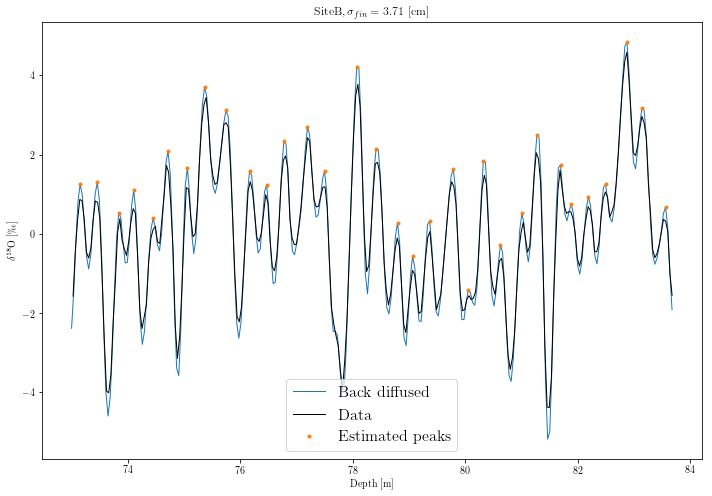

In [4]:

    # Plot original data, back diffused data and peak estimations
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(depth, data, lw=1, label='Back diffused')
ax.plot(depth_LT, d18O_LT-np.mean(d18O_LT),color='k', lw=1, label = 'Data')
ax.plot(depth[peaks], data[peaks],'.',lw=1, label='Estimated peaks')
ax.set(xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]', title=coreName+'$, \sigma_{fin} =$ ' + f'{diffLen*100:.2f} [cm]')
ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig(coreName + '_peaks.jpg')



In [5]:
d_deconC = depth
x_deconC = data

In [6]:
def ACF(x,y, m):
    mu = np.mean(y)
    sigma = np.std(y)
    n = len(y)
    maxLag = len(y)
    ks = np.arange(0,maxLag-1,1)
    
    S = np.zeros(len(ks))
    
    for k in ks:
        for i in range(1, n - k):
            S[k] += (y[i] - mu)*(y[i+k] - mu)
            
        S[k] *= 1/((n - k) * sigma**2)
        
    ks = ks# * (x[1] - x[0])
    
    return ks[ks < m], S[ks < m]

def cycleEst(x, y, m):
    
    ks, S = ACF(x,y,m)
    plt.plot(ks,S)
    l = []
    for i in range(2,len(S)):
        if (S[i-1] > S[i-2]) & (S[i] < S[i-1]) & (ks[i] < m_lim):
            l.append(ks[i])
    l = l[0]
    plt.axvline(x=l)
    return l



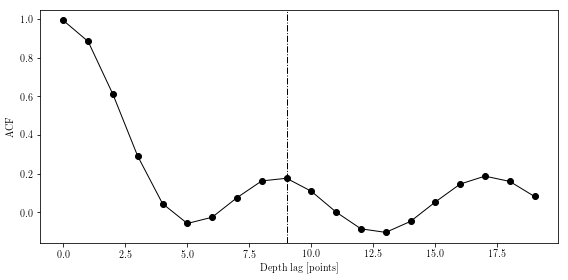

In [7]:
ks,S = ACF(depth,data,20)

figACF, axACF = plt.subplots(figsize=(8,4))
axACF.plot(ks, S, 'o-', color='k',lw=1)
axACF.set(xlabel='Depth lag [points]', ylabel='ACF')
axACF.axvline(x=ks[9], color='k',ls='-.',lw=1)
figACF.tight_layout()

saveFigs=True
if saveFigs:
    figACF.savefig('../WrittenWork/NovemberPresentation/figACF.eps')

In [8]:
def calcBounds(x, y, m, bounds_init):
    
    m_lim = m
    cycLen = np.zeros(len(bounds_init)-1)
    Ncycs = np.zeros(len(bounds_init)-1)
    
    for i in range(1,len(bounds_init)):
        idxMin = i-1
        idxMax = i

        x1 = x[(x > bounds_init[idxMin]) & (x <= bounds_init[idxMax])]
        y1 = y[(x > bounds_init[idxMin]) & (x <= bounds_init[idxMax])]

        cycLen[i-1] = cycleEst(x1, y1, m_lim)
        Ncycs[i-1] = len(x1)/cycLen[i-1]
     
    secPoints = cycLen*len(x)/sum(cycLen)
    secPoints = [int(N) for N in secPoints]
    
    cycPoints_tot = np.cumsum(secPoints)
    
    cycleSecBoundsNEW = np.append(x[0],x[cycPoints_tot])
    
    return cycLen, secPoints, cycleSecBoundsNEW, Ncycs



from itertools import groupby

def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)



def detBounds(x, y, m, bounds_init, cycLen_init, secPoints_init, Ncycs_init):
    cycLen = cycLen_init
    bounds = bounds_init
    secPoints = secPoints_init
    Ncycs = Ncycs_init
    i = 0
    
    m_lim = m
    while i < 1000:
        print(Ncycs.round(0))
        if not all_equal(Ncycs.round(0)):
            
            
            print(i)
            bounds_in = bounds
            cycLen, secPoints, bounds, Ncycs = calcBounds(x,y, m_lim, bounds_in)
            
            i += 1
        else:
            return bounds, secPoints, Ncycs



In [9]:
N_secs = 5

cycleSecBounds = np.linspace(d_deconC.min(), d_deconC.max(), N_secs+1)#np.append(np.arange(d_deconC.min(), d_deconC.max(),cycleSec_len), d_deconC.max())

m_lim = N_secs*10

[6. 5. 5. 6. 7.]
0
[6. 6. 6. 5. 6.]
1
[6. 6. 6. 6. 5.]
2
[6. 5. 5. 6. 5.]
3
[6. 6. 6. 6. 6.]


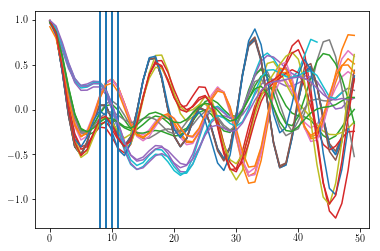

In [10]:
cycLen_init, secPoints_init, bounds_init, Ncycs_init = calcBounds(d_deconC,x_deconC, m_lim, cycleSecBounds)

boundsFin, NsFin, nCsFin =detBounds(d_deconC, x_deconC, m_lim, bounds_init, cycLen_init, secPoints_init, Ncycs_init)

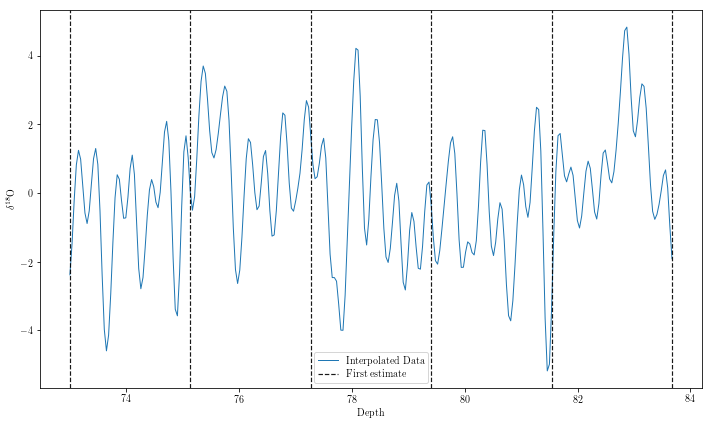

In [11]:
figSignal, axSignal = plt.subplots(figsize=(10,6))
axSignal.plot(d_deconC, x_deconC, label='Interpolated Data',lw=1)
axSignal.set(xlabel='Depth', ylabel='$\delta^{18}$O')
for bound in cycleSecBounds:
    axSignal.axvline(x=bound,color='k',ls='--',lw=1.2,alpha=0.9, label='First estimate')
    
#for i in range(len(boundsFin)):

#    axSignal.axvline(x=boundsFin[i],color='k',lw=1.6, label='Final estimate')
axSignal.legend()
figSignal.tight_layout()


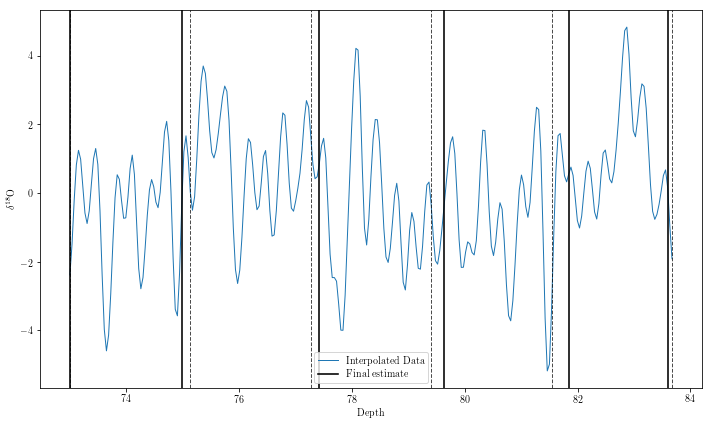

In [12]:
figSignal1, axSignal1 = plt.subplots(figsize=(10,6))
axSignal1.plot(d_deconC, x_deconC, label='Interpolated Data',lw=1)
axSignal1.set(xlabel='Depth', ylabel='$\delta^{18}$O')
for bound in cycleSecBounds:
    axSignal1.axvline(x=bound,color='k',ls='--',lw=1,alpha=0.7)
    
for i in range(len(boundsFin)):

    axSignal1.axvline(x=boundsFin[i],color='k',lw=1.6, label='Final estimate')
axSignal1.legend()

figSignal1.tight_layout()



In [13]:
d_secs = []
x_secs = []
Ns_secs = []
nPointsInCycs = []
nPointsInCyc = NsFin/nCsFin

points = np.diff(NsFin)
for i in range(0,N_secs):
    dMin = boundsFin[i-1]
    dMax = boundsFin[i]
    
    d_secs.append(d_deconC[(d_deconC >= dMin) & (d_deconC < dMax)])
    x_secs.append(x_deconC[(d_deconC >= dMin) & (d_deconC < dMax)])
    Ns = len(x_deconC[(d_deconC >= dMin) & (d_deconC < dMax)])
    Ns_secs.append(np.ones(Ns) * Ns)
    
    nPointsInCycs.append(np.ones(Ns))
    
Ns_secs = np.concatenate(Ns_secs)


d_secs = np.concatenate(d_secs)
x_secs = np.concatenate(x_secs)

nPointsInCycs = np.concatenate(nPointsInCycs*nPointsInCyc)
#len(d_deconC)

In [14]:
mus = np.zeros(len(d_secs))
x_secsT = np.concatenate([np.zeros(int(nPointsInCyc[0]/2)), x_secs,np.zeros(int(nPointsInCyc[-1]/2))])


In [15]:
xStart = int(nPointsInCyc[0]/2)
xEnd = int(len(x_secsT) - nPointsInCyc[-1]/2)

mus = np.zeros(len(d_secs))
sigmas = np.zeros(len(d_secs))

for i in range(xStart+1,xEnd):
    li = nPointsInCycs[i-xStart]
    sumStart = int(i - li/2)
    sumEnd = int(i+li/2)
    #print(f'Start:{sumStart}')
    #print(li)
    #print(f'Slut:{sumEnd}\n')
    mus[i-xStart-1] = sum(x_secsT[sumStart:sumEnd]/(li+1))
    sigmas[i-xStart-1] = sum((x_secsT[sumStart:sumEnd] - mus[i-xStart-1])**2/(li+1))

27

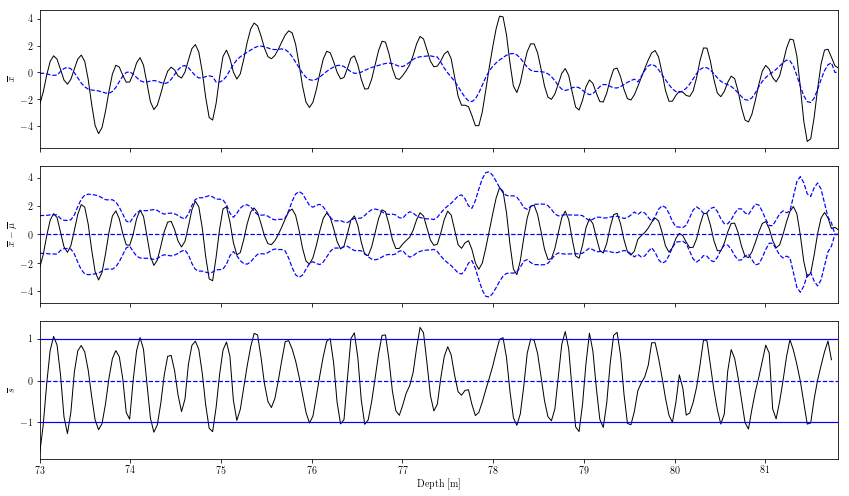

In [17]:
fig,ax = plt.subplots(3,1,figsize=(12,7), sharex=True)
ax[0].plot(d_secs,x_secs,color='k',lw=1)
ax[0].plot(d_secs,mus,color='blue',ls='--', lw=1.2)
ax[0].set(xlim=(d_secs.min(),d_secs.max()), ylabel='$\overline{x}$')#(70.90,80.85))#

#ax[1].plot(d_secs,x_secs)
ax[1].plot(d_secs,x_secs-mus,color='k',lw=1)
ax[1].axhline(y=0,color='blue', ls='--', lw=1.2)
ax[1].plot(d_secs, np.sqrt(2)*np.sqrt(sigmas),color='blue',ls='--', lw=1.2)
ax[1].plot(d_secs, -np.sqrt(2)*np.sqrt(sigmas),color='blue',ls='--', lw=1.2)
ax[1].set(ylabel='$\overline{x} - \overline{\mu}$')


s = (x_secs[:-2]-mus[:-2])/(np.sqrt(2)*np.sqrt(sigmas[:-2]))
ax[2].plot(d_secs[:-2],s, color='k', lw=1)
ax[2].axhline(y=0,color='blue', ls='--', lw=1.2)
ax[2].axhline(y=-1,color='blue', lw=1.2)
ax[2].axhline(y=1,color='blue', lw=1.2)
ax[2].set(ylabel='$\overline{s}$', xlabel='Depth [m]')
fig.tight_layout()
#ax[2].plot(d_secs,x_secs,lw=1)


Number of cycles in each section: 5.56


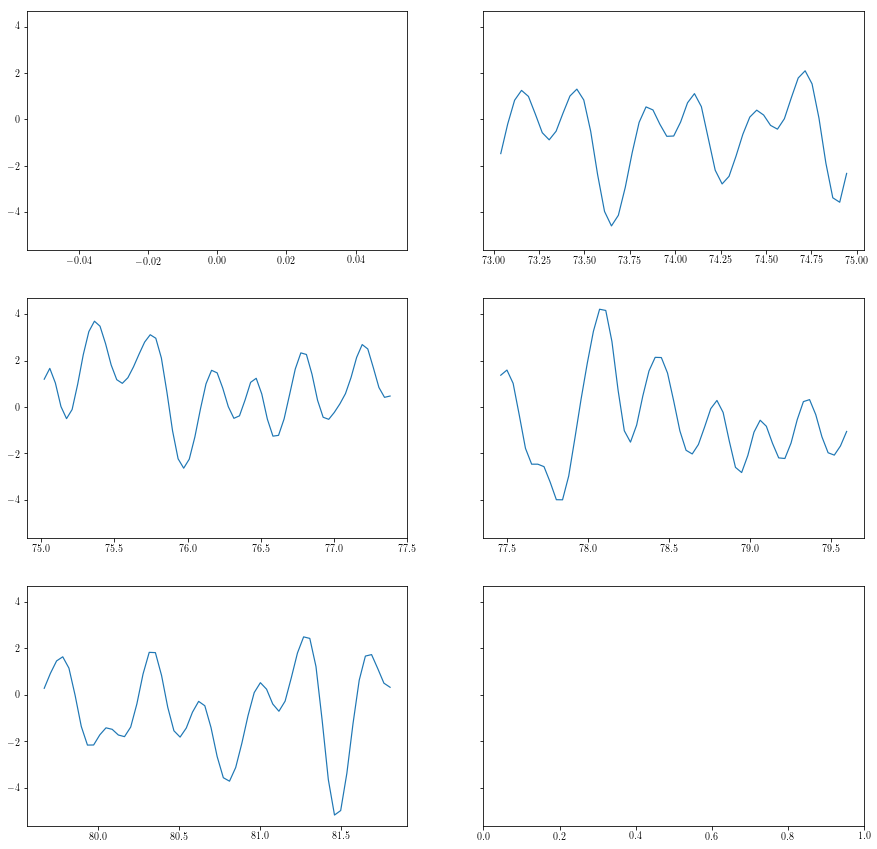

In [172]:

figSignal, axSignal = plt.subplots(int(np.ceil(N_secs/2)),2,figsize=(15,15),sharey=True)

for ax,i in zip(axSignal.flatten(), range(N_secs)):
    dMin = boundsFin[i-1]
    dMax = boundsFin[i]
    ax.plot(d_deconC[(d_deconC > dMin) & (d_deconC < dMax)], x_deconC[(d_deconC > dMin) & (d_deconC < dMax)], label='Deconvoluted Data', lw=1.2)
print(f'Number of cycles in each section: {nCsFin[0]:.2f}')